<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/tutorials/W2D4_GenerativeModels/student/W2D4_Tutorial2.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D4_GenerativeModels/student/W2D4_Tutorial2.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# Tutorial 2: Diffusion models

**Week 2, Day 4: Generative Models**

**By Neuromatch Academy**

__Content creators:__ Binxu Wang

__Content reviewers:__ Shaonan Wang, Dongrui Deng, Dora Zhiyu Yang, Adrita Das

__Content editors:__ Shaonan Wang

__Production editors:__ Spiros Chavlis

---
# Tutorial Objectives

* Understand the idea behind Diffusion generative models: using score to enable reversal of diffusion process.
* Learn the score function by learning to denoise data.
* Hands-on experience in learning the score to a generate certain distribution.


### How to use this notebook today
- Run top-to-bottom; cells marked "Coding Exercise" need your edits before downstream tests will pass.
- Keep an eye on shapes and scales (especially sigma_t); most bugs come from mismatched broadcasting.
- Minimal path if time is short: interactive score visualizations -> reverse SDE coding cell -> DSM loss coding cell -> quick sampler run.
- Stretch goals: tune Lambda, nsteps, and compare how samples change.


In [1]:
# @markdown
from IPython.display import IFrame
from ipywidgets import widgets

---
# Setup

##  Install dependencies


In [2]:
# @title Install dependencies
# !pip install pillow --quiet
# !pip install seaborn --quiet

In [3]:
# Imports
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

##  Figure settings


In [4]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
# %config InlineBackend.figure_format = 'retina'
# plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

##  Plotting functions


In [5]:
# @title Plotting functions
import logging
import pandas as pd
import matplotlib.lines as mlines
logging.getLogger('matplotlib.font_manager').disabled = True
plt.rcParams['axes.unicode_minus'] = False
# You may have functions that plot results that aren't
# particularly interesting. You can add these here to hide them.

def plotting_z(z):
  """This function multiplies every element in an array by a provided value

  Args:
    z (ndarray): neural activity over time, shape (T, ) where T is number of timesteps

   """

  fig, ax = plt.subplots()

  ax.plot(z)
  ax.set(
      xlabel='Time (s)',
      ylabel='Z',
      title='Neural activity over time'
      )


def kdeplot(pnts, label="", ax=None, titlestr=None, handles=[], color="", **kwargs):
  if ax is None:
    ax = plt.gca()#figh, axs = plt.subplots(1,1,figsize=[6.5, 6])
  sns.kdeplot(x=pnts[:,0], y=pnts[:,1], ax=ax, label=label, color=color, **kwargs)
  handles.append(mlines.Line2D([], [], color=color, label=label))
  if titlestr is not None:
    ax.set_title(titlestr)


def quiver_plot(pnts, vecs, *args, **kwargs):
  plt.quiver(pnts[:, 0], pnts[:,1], vecs[:, 0], vecs[:, 1], *args, **kwargs)


def gmm_pdf_contour_plot(gmm, xlim=None,ylim=None,ticks=100,logprob=False,label=None,**kwargs):
    if xlim is None:
        xlim = plt.xlim()
    if ylim is None:
        ylim = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(*xlim, ticks), np.linspace(*ylim, ticks))
    pdf = gmm.pdf(np.dstack((xx,yy)))
    if logprob:
        pdf = np.log(pdf)
    plt.contour(xx, yy, pdf, **kwargs,)


def visualize_diffusion_distr(x_traj_rev, leftT=0, rightT=-1, explabel=""):
  if rightT == -1:
    rightT = x_traj_rev.shape[2]-1
  figh, axs = plt.subplots(1,2,figsize=[12,6])
  sns.kdeplot(x=x_traj_rev[:,0,leftT], y=x_traj_rev[:,1,leftT], ax=axs[0])
  axs[0].set_title("Density of Gaussian Prior of $x_T$\n before reverse diffusion")
  plt.axis("equal")
  sns.kdeplot(x=x_traj_rev[:,0,rightT], y=x_traj_rev[:,1,rightT], ax=axs[1])
  axs[1].set_title(f"Density of $x_0$ samples after {rightT} step reverse diffusion")
  plt.axis("equal")
  plt.suptitle(explabel)
  return figh

In [6]:
def indiv_gauss_pdf_contour_plot(
    gmm,
    xlim=None,
    ylim=None,
    ticks=100,
    levels=20,
    cmap='viridis',
    linewidths=1.0,
    alpha=0.9,
):
    """Plot PDF contours for every Gaussian component using the current axes."""
    import numpy as np
    import matplotlib.pyplot as plt

    ax = plt.gca()
    if xlim is None:
        xlim = plt.xlim()
    if ylim is None:
        ylim = plt.ylim()

    xx, yy = np.meshgrid(
        np.linspace(*xlim, ticks),
        np.linspace(*ylim, ticks)
    )
    pos = np.dstack((xx, yy))

    colors = plt.get_cmap(cmap)(np.linspace(0.15, 0.85, gmm.n_component))

    for idx, (rv, mean, color) in enumerate(zip(gmm.RVs, gmm.mus, colors)):
        pdf = rv.pdf(pos)
        ax.contour(
            xx,
            yy,
            pdf,
            levels=levels,
            colors=[color],
            linewidths=linewidths,
            alpha=alpha,
        )
        ax.scatter(
            mean[0],
            mean[1],
            marker='x',
            s=80,
            color=color,
            label=f"Gaussian {idx + 1}",
        )

    return ax

##  Set random seed


 Executing `set_seed(seed=seed)` you are setting the seed


In [7]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

##  Set device (GPU or CPU). Execute `set_device()`


In [8]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [9]:
SEED = 1337
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 1337 has been set.


---

# Section 1: Understanding Score and Diffusion



## Notes: score-based model vs. diffusion model

In the field, [**score-based model**](https://yang-song.net/blog/2021/score/) and [**diffusion models**](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) are often used interchangeably. At first, they were developed semi-independently, so they have different formulations and notations. On the surface.

* Diffusion model uses a discrete Markov chain as a forward process. The objective is derived via the Evidence Lower Bound (ELBO) of the latent model.
* Score-based model usually uses continuous-time stochastic differential equation (SDE). The objective is derived via denoising score matching.

In the end, they were found to be equivalent, as one is roughly the discretization of the other. Here we focus on the **continuous time** framework, as it's conceptual simplicity similar to [this synopsis](https://arxiv.org/abs/2206.00364).

###  Video 1: Intro and Principles


In [10]:
# @title Video 1: Intro and Principles
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'a9uLb8Pf4pM'), ('Bilibili', 'BV1kV411g7gy')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

###  Video 2: Math Behind Diffusion


In [11]:
# @title Video 2: Math Behind Diffusion
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'qDXPZqYm-1g'), ('Bilibili', 'BV19a4y1c7We')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

###  Submit your feedback


## Section 1.1:  Diffusion Process

In this section, we'd like to understand the forward diffusion process, and gain intuition about how diffusion turns data into "noise".

In this tutorial, we will use the process also known as Variance Exploding SDE (VPSDE) in diffusion literature.

\begin{equation}
d\mathbf x=g(t)d\mathbf w
\end{equation}

$d\mathbf w$ is the differential of the Wiener process, which is like the Gaussian random noise; $g(t)$ is the diffusion coefficient at time $t$. In our code, we can discretize it as:

\begin{equation}
\mathbf{x}_{t+\Delta t} = \mathbf{x}_{t}+g(t) \sqrt{\Delta t} z_t
\end{equation}

where $z_t\sim \mathcal{N} (0,I)$ are independent and identically distributed (i.i.d.) normal random variable.

Given an initial state $\mathbf{x}_0$ the conditional distribution of $\mathbf{x}_t$ is a Gaussian around $\mathbf x_0$:

\begin{equation}
p(\mathbf{x}_t\mid \mathbf{x}_0) = \mathcal N(\mathbf{x}_t;\mathbf{x}_0,\sigma_t^2 I)
\end{equation}

The key quantity to note is the $\sigma_t$ which is the integrated noise scale at time $t$. $I$ denotes the identity matrix.

\begin{equation}
\sigma_t^2=∫_0^t g^2(\tau)d\tau
\end{equation}

Marginalizing over all the initial states, the distribution of $\mathbf x_t$ is $p_t(x_t)$, i.e., convolving a Gaussian over the initial data distribution $p_0(\mathbf x_0)$ which blurs the data up.

\begin{equation}
p_t(\mathbf{x}_t) = \int_{\mathbf x_0} p_0(\mathbf x_0)\mathcal N(\mathbf{x}_t;\mathbf{x}_0,\sigma_t^2 I)
\end{equation}

### Interactive Demo 1.1: Visualizing diffusion

Here, we will examine the evolution of the density of a distribution $p_t(\mathbf{x})$ undergoing forward diffusion. In this case, we let $g(t)=\lambda^{t}$.

####  1D diffusion process


In [12]:
# @title 1D diffusion process
@widgets.interact
def diffusion_1d_forward(Lambda=(0, 50, 1), ):
  np.random.seed(0)
  timesteps = 100
  sampleN = 200
  t = np.linspace(0, 1, timesteps)
  # Generate random normal samples for the Wiener process
  dw = np.random.normal(0, np.sqrt(t[1] - t[0]), size=(len(t), sampleN))  # Three-dimensional array for multiple trajectories
  # Sample initial positions from a bimodal distribution
  x0 = np.concatenate((np.random.normal(-5, 1, size=(sampleN//2)),
                       np.random.normal(5, 1, size=(sampleN - sampleN//2))), axis=-1)
  # Compute the diffusion process for multiple trajectories
  x = np.cumsum((Lambda**t[:,None]) * dw, axis=0) + x0.reshape(1,sampleN)  # Broadcasting x0 to match the shape of dw
  # Plot the diffusion process
  plt.plot(t, x[:,:sampleN//2], alpha=0.1, color="r") # traj from first mode
  plt.plot(t, x[:,sampleN//2:], alpha=0.1, color="b") # traj from second mode
  plt.xlabel('Time')
  plt.ylabel('x')
  plt.title('Diffusion Process with $g(t)=\\lambda^{t}$'+f' $\\lambda$={Lambda}')
  plt.grid(True)
  plt.show()

interactive(children=(IntSlider(value=25, description='Lambda', max=50), Output()), _dom_classes=('widget-inte…

####  2D diffusion process


 (the animation takes a while to render)


In [13]:
# @title 2D diffusion process
# @markdown (the animation takes a while to render)
Lambda = 26  # @param {type:"slider", min:1, max:50, step:1}
timesteps = 50
sampleN = 200
t = np.linspace(0, 1, timesteps)
# Generate random normal samples for the Wiener process
dw = np.random.normal(0, np.sqrt(t[1] - t[0]), size=(len(t), 2, sampleN))  # Three-dimensional array for multiple trajectories
# Sample initial positions from a bimodal distribution
x0 = np.concatenate((np.random.normal(-2, .2, size=(2,sampleN//2)),
                     np.random.normal(2, .2, size=(2,sampleN - sampleN//2))),
                    axis=-1)
# Compute the diffusion process for multiple trajectories
x = np.cumsum((Lambda**t)[:, None, None] * dw, axis=0) + x0[None, :, :]  # Broadcasting x0 to match the shape of dw

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-25, 25)
ax.set_ylim(-25, 25)
ax.axis("image")
# Create an empty scatter plot
scatter1 = ax.scatter([], [], color="r", alpha=0.5)
scatter2 = ax.scatter([], [], color="b", alpha=0.5)
# Update function for the animation
def update(frame):
  ax.set_title(f'Time Step: {frame}')
  scatter1.set_offsets(x[frame, :, :sampleN//2].T)
  scatter2.set_offsets(x[frame, :, sampleN//2:].T)
  return scatter1, scatter2

# Create the animation
animation = FuncAnimation(fig, update, frames=range(timesteps), interval=100, blit=True)
# Display the animation
plt.close()  # Prevents displaying the initial static plot
HTML(animation.to_html5_video()) #  to_jshtml

## Section 1.2:  What is Score

The big idea of diffusion model is to use the **"score" function** to reverse the diffusion process. So what is score, what's the intuition to it?

The **Score** is the gradient of the log data distribution, so it tells us which direction to go to increase the probability of data.

\begin{equation}
\mathbf{s}(\mathbf{x})=\nabla \log p(\mathbf{x})
\end{equation}

### Coding Exercise 1.2: Score for Gaussian Mixtures

In this exercise, you will explore the score function of a Gaussian mixture to gain more intuition about its geometry.

####   Custom Gaussian Mixture class


 *Execute this cell to define the class Gaussian Mixture Model for our exercise*


In [14]:
# @title  Custom Gaussian Mixture class
# @markdown *Execute this cell to define the class Gaussian Mixture Model for our exercise*

from scipy.stats import multivariate_normal

class GaussianMixture:
  def __init__(self, mus, covs, weights):
    """
    mus: a list of K 1d np arrays (D,)
    covs: a list of K 2d np arrays (D, D)
    weights: a list or array of K unnormalized non-negative weights, signifying the possibility of sampling from each branch.
      They will be normalized to sum to 1. If they sum to zero, it will err.
    """
    self.n_component = len(mus)
    self.mus = mus
    self.covs = covs
    self.precs = [np.linalg.inv(cov) for cov in covs]
    self.weights = np.array(weights)
    self.norm_weights = self.weights / self.weights.sum()
    self.RVs = []
    for i in range(len(mus)):
      self.RVs.append(multivariate_normal(mus[i], covs[i]))
    self.dim = len(mus[0])

  def add_component(self, mu, cov, weight=1):
    self.mus.append(mu)
    self.covs.append(cov)
    self.precs.append(np.linalg.inv(cov))
    self.RVs.append(multivariate_normal(mu, cov))
    self.weights.append(weight)
    self.norm_weights = self.weights / self.weights.sum()
    self.n_component += 1

  def pdf_decompose(self, x):
    """
      probability density (PDF) at $x$.
    """
    component_pdf = []
    prob = None
    for weight, RV in zip(self.norm_weights, self.RVs):
        pdf = weight * RV.pdf(x)
        prob = pdf if prob is None else (prob + pdf)
        component_pdf.append(pdf)
    component_pdf = np.array(component_pdf)
    return prob, component_pdf

  def pdf(self, x):
    """
      probability density (PDF) at $x$.
    """
    prob = None
    for weight, RV in zip(self.norm_weights, self.RVs):
        pdf = weight * RV.pdf(x)
        prob = pdf if prob is None else (prob + pdf)
    # component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    # prob = np.dot(component_pdf, self.norm_weights)
    return prob

  def score(self, x):
    """
    Compute the score $\\nabla_x \\log p(x)$ for the given $x$.
    """
    component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    print("component_pdf:", component_pdf.shape, component_pdf)
    weighted_compon_pdf = component_pdf * self.norm_weights[np.newaxis, :]
    print("self.norm_weights:", self.norm_weights.shape, self.norm_weights)
    participance = weighted_compon_pdf / weighted_compon_pdf.sum(axis=1, keepdims=True)
    print("participance:", participance.shape, participance)

    scores = np.zeros_like(x)
    for i in range(self.n_component):
      gradvec = - (x - self.mus[i]) @ self.precs[i]
      scores += participance[:, i:i+1] * gradvec

    return scores

  def score_decompose(self, x):
    """
    Compute the grad to each branch for the score $\\nabla_x \\log p(x)$ for the given $x$.
    """
    component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    weighted_compon_pdf = component_pdf * self.norm_weights[np.newaxis, :]
    participance = weighted_compon_pdf / weighted_compon_pdf.sum(axis=1, keepdims=True)

    gradvec_list = []
    for i in range(self.n_component):
      gradvec = - (x - self.mus[i]) @ self.precs[i]
      gradvec_list.append(gradvec)
      # scores += participance[:, i:i+1] * gradvec

    return gradvec_list, participance

  def sample(self, N):
    """ Draw N samples from Gaussian mixture
    Procedure:
      Draw N samples from each Gaussian
      Draw N indices, according to the weights.
      Choose sample between the branches according to the indices.
    """
    rand_component = np.random.choice(self.n_component, size=N, p=self.norm_weights)
    all_samples = np.array([rv.rvs(N) for rv in self.RVs])
    gmm_samps = all_samples[rand_component, np.arange(N),:]
    return gmm_samps, rand_component, all_samples

### Example: Gaussian mixture model

In [15]:
# Gaussian mixture
mu1 = np.array([0, 1.0])
Cov1 = np.array([[1.0, 0.0], [0.0, 1.0]])

mu2 = np.array([2.0, -1.0])
Cov2 = np.array([[2.0, 0.5], [0.5, 1.0]])

gmm = GaussianMixture([mu1, mu2],[Cov1, Cov2], [1.0, 1.0])

In [16]:
set_seed(1337)
gmm_samples, _, _ = gmm.sample(5000)


Random seed 1337 has been set.


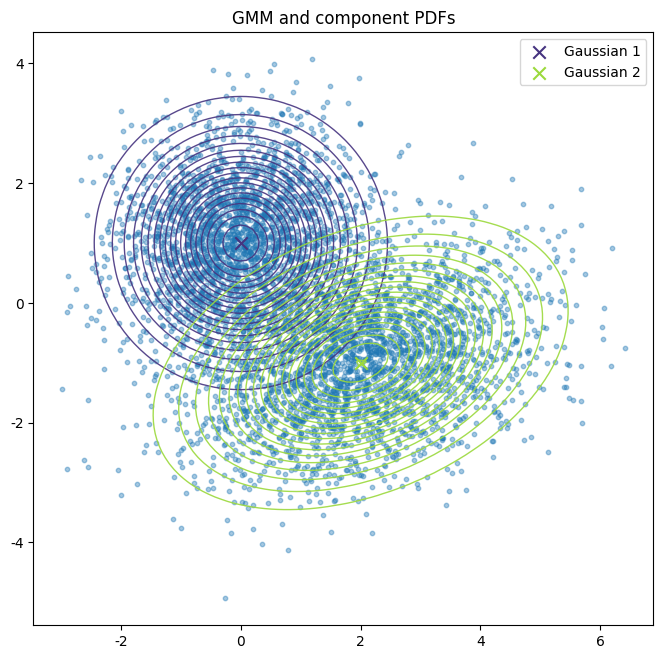

In [17]:
show_samples = True  # @param {type:"boolean"}
plt.figure(figsize=[8, 8])
plt.scatter(
    gmm_samples[:, 0],
    gmm_samples[:, 1],
    s=10,
    alpha=0.4 if show_samples else 0.0,
)
indiv_gauss_pdf_contour_plot(gmm, cmap="viridis", levels=20)
plt.title("GMM and component PDFs")
plt.axis("image")
plt.legend(loc="upper right")
plt.show()

####  Visualize log density


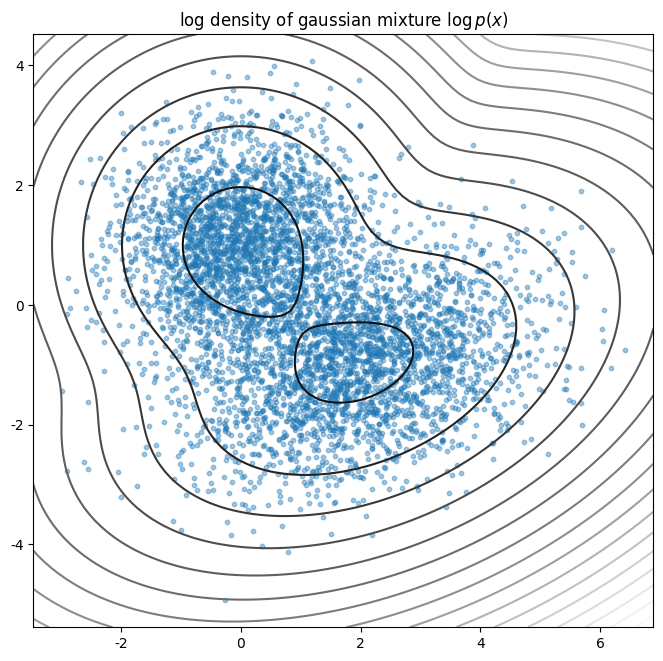

In [18]:
# @title Visualize log density
show_samples = True  # @param {type:"boolean"}
plt.figure(figsize=[8, 8])
plt.scatter(gmm_samples[:, 0],
            gmm_samples[:, 1],
            s=10,
            alpha=0.4 if show_samples else 0.0)
gmm_pdf_contour_plot(gmm, cmap="Greys", levels=20, logprob=True)
plt.title("log density of gaussian mixture $\\log p(x)$")
plt.axis("image")
plt.show()

####  Visualize Score


In [19]:
# @title Visualize Score
set_seed(2023)
gmm_samps_few, _, _ = gmm.sample(200)
scorevecs_few = gmm.score(gmm_samps_few)
gradvec_list, participance = gmm.score_decompose(gmm_samps_few)

Random seed 2023 has been set.
component_pdf: (200, 2) [[1.21402287e-01 1.44717362e-04]
 [4.10315906e-04 7.18753687e-02]
 [1.77434079e-03 4.11446393e-02]
 [5.20932752e-03 6.46453088e-09]
 [1.26953905e-01 3.36827083e-03]
 [1.26103568e-01 1.94130545e-04]
 [9.74504759e-02 1.83678799e-02]
 [1.83742229e-02 7.72710733e-02]
 [8.16248066e-06 3.37844658e-02]
 [5.02238501e-04 1.01734113e-01]
 [8.47933578e-02 7.25026930e-05]
 [6.46218312e-08 6.06136771e-03]
 [6.61773807e-02 3.46889183e-03]
 [1.87607136e-02 8.66956292e-02]
 [1.26248916e-01 1.62010288e-04]
 [6.34765222e-02 2.12064358e-04]
 [9.65492972e-02 2.87089505e-05]
 [7.22864185e-02 3.08307565e-02]
 [1.40686167e-01 3.09738152e-04]
 [5.99634538e-02 5.31633513e-03]
 [2.45066279e-02 1.73595295e-02]
 [3.16551241e-02 1.98909610e-04]
 [6.45867984e-03 5.65399605e-09]
 [1.60612250e-02 1.22110106e-07]
 [7.18316097e-02 2.70202479e-03]
 [2.08833546e-02 1.46671246e-02]
 [4.78462564e-02 3.92887791e-05]
 [6.50765842e-02 2.52412954e-02]
 [1.09795794e-01 1.26

####  Score for Gaussian mixture


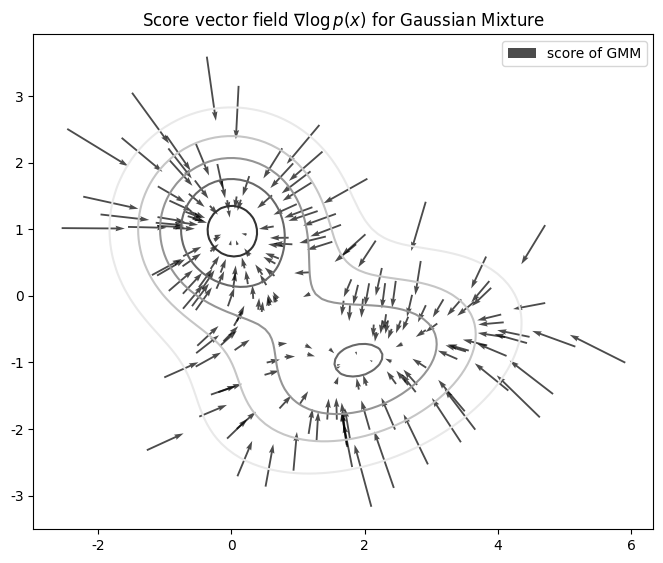

In [20]:
# @title Score for Gaussian mixture
plt.figure(figsize=[8, 8])
quiver_plot(gmm_samps_few, scorevecs_few,
            color="black", scale=25, alpha=0.7, width=0.003,
            label="score of GMM")
gmm_pdf_contour_plot(gmm, cmap="Greys")
plt.title("Score vector field $\\nabla\\log p(x)$ for Gaussian Mixture")
plt.axis("image")
plt.legend()
plt.show()

####  Score for each Gaussian mode


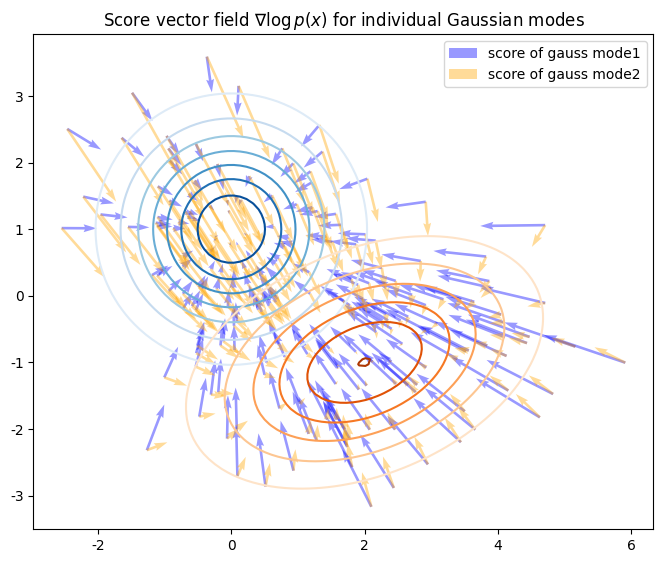

In [21]:
# @title Score for each Gaussian mode
plt.figure(figsize=[8, 8])
quiver_plot(gmm_samps_few, gradvec_list[0],
            color="blue", alpha=0.4, scale=45,
            label="score of gauss mode1")
quiver_plot(gmm_samps_few, gradvec_list[1],
            color="orange", alpha=0.4, scale=45,
            label="score of gauss mode2")
gmm_pdf_contour_plot(gmm.RVs[0], cmap="Blues")
gmm_pdf_contour_plot(gmm.RVs[1], cmap="Oranges")
plt.title("Score vector field $\\nabla\\log p(x)$ for individual Gaussian modes")
plt.axis("image")
plt.legend()
plt.show()

####  Compare Score of individual mode with that of the mixture.


<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1986320/3425403933.py:13: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Score vector field $\\nabla\log p(x)$ of mixture")


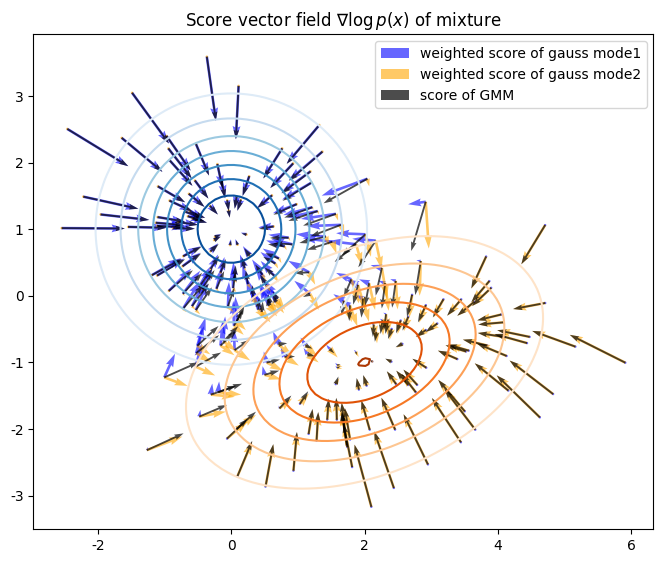

In [22]:
# @title Compare Score of individual mode with that of the mixture.
plt.figure(figsize=[8, 8])
quiver_plot(gmm_samps_few, gradvec_list[0]*participance[:, 0:1],
            color="blue", alpha=0.6, scale=25,
            label="weighted score of gauss mode1")
quiver_plot(gmm_samps_few, gradvec_list[1]*participance[:, 1:2],
            color="orange", alpha=0.6, scale=25,
            label="weighted score of gauss mode2")
quiver_plot(gmm_samps_few, scorevecs_few, color="black", scale=25, alpha=0.7,
            width=0.003, label="score of GMM")
gmm_pdf_contour_plot(gmm.RVs[0], cmap="Blues")
gmm_pdf_contour_plot(gmm.RVs[1], cmap="Oranges")
plt.title("Score vector field $\\nabla\log p(x)$ of mixture")
plt.axis("image")
plt.legend()
plt.show()


### Think! 1.2: What does score tell us?

What does the score's **magnitude and direction** tell us in general?

For a **multi-modal distribution**, how does the score of the individual mode relate to the overall score?

Take 2 minutes to think in silence, then discuss as a group (~10 minutes).

<details><summary>Answer</summary>
Direction points toward higher-density regions (uphill), magnitude grows with distance from a mode. For a multi-modal distribution (e.g., GMM), the overall score is a weighted average of per-mode scores, dominated by nearby/high-density modes; each point’s score is pulled toward the closest modes.
</details>


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W2D4_GenerativeModels/solutions/W2D4_Tutorial2_Solution_df13ac7f.py)



####  Submit your feedback


In [23]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_What_does_score_tell_us_Discussion")

NameError: name 'content_review' is not defined

## Section 1.3:  Reverse Diffusion

After getting some intuition about the score function, we are now well-equipped to reverse the diffusion process!

There is [a result in stochastic process literature](https://www.sciencedirect.com/science/article/pii/0304414982900515) that if we have the forward process

\begin{equation}
d\mathbf{x} = g(t)d \mathbf{w}
\end{equation}

Then the following process (reverse SDE) will be its time reversal:

\begin{equation}
d\mathbf{x} = -g^2(t) \nabla_\mathbf{x} \log p_t(\mathbf{x}) dt + g(t) d \mathbf{w}.
\end{equation}

where time $t$ runs backward.

<br>

**Time Reversal**: The solution of forward SDE is a sequence of distribution $p_t(\mathbf{x})$ from $t=0\to T$. If we start the reverse SDE with the initial distribution $p_T(\mathbf{x})$, then its solution will be the same sequence of distribution $p_t(\mathbf{x})$, but only that $t=T\to 0$.

**Note:** For the general form of this result, see the Bonus section at the end of this tutorial.

**Implication**  This time reversal is the foundation of the Diffusion model. We can use an interesting distribution as $p_0(\mathbf x)$ connects it with noise via forward diffusion.

Then we can sample the noise and convert it back to data via the reverse diffusion process.

<br>

<p align='center'><img src='https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/W3D1_TimeSeriesAndNaturalLanguageProcessing/static/noising_process.png?raw=True'/></p>


**Checkpoint before Coding Exercise 1.3**
- Intuition: reverse SDE adds noise *and* follows the score uphill; leaving out either term breaks sampling.
- Inputs you need: current sample x_t, noise scale g(t)=Lambda^t, score at time t from `gmm_t.score`.
- Expected behavior: early steps look noisy, later steps collapse toward mixture modes.


### Coding Exercise 1.3: Score enables reversal of diffusion

Here let's put our knowledge into action and see that the **score function** indeed enables the reverse diffusion and **the recovery of the initial distribution.**

In the following cell, you are going to implement the discretization of the reverse diffusion equation:

\begin{equation}
\mathbf{x}_{t-\Delta t} = \mathbf{x}_t + g(t)^2 s(\mathbf{x}_t, t)\Delta t + g(t)\sqrt{\Delta t} \mathbf{z}_t
\end{equation}

where $\mathbf{z}_t \sim \mathcal{N}(\mathbf{0}, I)$ and $g(t)=\lambda^t$.

In fact, this is the *sampling equation* for diffusion models in its simplest version.

 Helper functions: `sigma_t_square` and `diffuse_gmm`


In [ ]:
# @markdown Helper functions: `sigma_t_square` and `diffuse_gmm`
def sigma_t_square(t, Lambda):
    """Compute the noise variance \sigma_t^2 of the conditional distribution
    for forward process with g(t)=\lambda^t

    Formula
      \sigma_t^2 = \frac{\sigma^{2\lambda} - 1}{2 \ln(\lambda)}

    Args:
      t (scalar or ndarray): time
      Lambda (scalar): Lambda

    Returns:
      sigma_t^2
    """
    return (Lambda**(2 * t) - 1) / (2 * np.log(Lambda))


def sigma_t(t, Lambda):
    """Compute the noise std \sigma_t of the conditional distribution
    for forward process with g(t)=\lambda^t

    Formula
      \sigma_t =\sqrt{ \frac{\sigma^{2\lambda} - 1}{2 \ln(\lambda)}}

    Args:
      t (scalar or ndarray): time
      Lambda (scalar): Lambda

    Returns:
      sigma_t
    """
    return np.sqrt((Lambda**(2 * t) - 1) / (2 * np.log(Lambda)))


def diffuse_gmm(gmm, t, Lambda):
  """ Teleport a Gaussian Mixture distribution to $t$ by diffusion forward process

  The distribution p_t(x) (still a Gaussian mixture)
    following the forward diffusion SDE
  """
  sigma_t_2 = sigma_t_square(t, Lambda)  # variance
  noise_cov = np.eye(gmm.dim) * sigma_t_2
  covs_dif = [cov + noise_cov for cov in gmm.covs]
  return GaussianMixture(gmm.mus, covs_dif, gmm.weights)

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1055542/453161101.py:3: SyntaxWarning: invalid escape sequence '\s'
  """Compute the noise variance \sigma_t^2 of the conditional distribution
/tmp/ipykernel_1055542/453161101.py:20: SyntaxWarning: invalid escape sequence '\s'
  """Compute the noise std \sigma_t of the conditional distribution


In [ ]:

def reverse_diffusion_SDE_sampling_gmm(gmm, sampN=500, Lambda=5, nsteps=500):
  """ Using exact score function to simulate the reverse SDE to sample from distribution.

  gmm: Gausian Mixture model class defined above
  sampN: Number of samples to generate
  Lambda: the $\lambda$ used in the diffusion coefficient $g(t)=\lambda^t$
  nsteps: how many discrete steps do we use to
  """
  # initial distribution $N(0,sigma_T^2 I)$
  sigmaT2 = sigma_t_square(1, Lambda)
  xT = np.sqrt(sigmaT2) * np.random.randn(sampN, 2)
  x_traj_rev = np.zeros((*xT.shape, nsteps, ))
  x_traj_rev[:,:,0] = xT
  dt = 1 / nsteps
  for i in range(1, nsteps):
    # note the time fly back $t$
    t = 1 - i * dt

    # Sample the Gaussian noise $z ~ N(0, I)$
    eps_z = np.random.randn(*xT.shape)

    # Transport the gmm to that at time $t$ and
    gmm_t = diffuse_gmm(gmm, t, Lambda)

    # Compute the score at state $x_t$ and time $t$, $nabla \log p_t(x_t)$
    score_xt = gmm_t.score(x_traj_rev[:, :, i-1])

    # Implement the one time step update equation
    x_traj_rev[:, :, i] = x_traj_rev[:, :, i-1] + eps_z * (Lambda ** t) * np.sqrt(dt) + score_xt * dt * Lambda**(2*t)
  return x_traj_rev


<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1055542/1266828278.py:2: SyntaxWarning: invalid escape sequence '\l'
  """ Using exact score function to simulate the reverse SDE to sample from distribution.


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W2D4_GenerativeModels/solutions/W2D4_Tutorial2_Solution_c3981c22.py)

*Example output:*

<img alt='Solution hint' align='left' width=625.0 height=575.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D4_GenerativeModels/static/W2D4_Tutorial2_Solution_c3981c22_1.png>



####  Submit your feedback


In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Score_enables_Reversal_of_Diffusion_Exercise")

---
# Section 2: Learning the score by denoising

So far, we have understood that the score function enables the time reversal of the diffusion process. But how to estimate it when we have no analytical form of the distribution?

For real datasets, we usually have no access to their density, not to mention their score. However, we have a set of samples $\{x_i\}$ from it. The way we estimate the score is called denoising score matching.

It can be shown that optimizing the upper objective, i.e., denoising score matching (DSM), is equivalent to optimizing the lower objective, i.e., explicit score matching, which minimizes the mean squared error (MSE) between the score model and the true time-dependent score.

\begin{equation}
J_{DSM}(\theta)=\mathbb E_{x\sim p_0(x)\\\tilde x\sim p_t(\tilde x\mid x)}\|s_\theta(\tilde x)-\nabla_\tilde x\log p_t(\tilde x\mid x)\|^2\\
J_{ESM}(\theta)=\mathbb E_{\tilde x\sim p_t(\tilde x)}\|s_\theta(\tilde x)-\nabla_\tilde x\log p_t(\tilde x)\|^2
\end{equation}

In both cases, the optimal $s_\theta(x)$ will be the same as the true score $\nabla_\tilde x\log p_t(\tilde x)$. Both objectives are equivalent in terms of their optimum.

Using the fact that the forward process has Gaussian conditional distribution $p_t(\tilde x\mid x)= \mathcal N(x,\sigma^2_t I)$, the objective can be simplified even further!

\begin{equation}
\mathbb E_{x\sim p_0(x)}\mathbb E_{z\sim \mathcal N(0,I)}\|s_\theta(x+\sigma_t z)+\frac{1}{\sigma_t}z\|^2
\end{equation}

To train the score model for all $t$ or noise levels, the objective is integrated over all time $t\in[\epsilon,1]$, with particular weighting $\gamma_t$ of different times:

\begin{equation}
\int_\epsilon^1dt \gamma_t\mathbb E_{x\sim p_0(x)}\mathbb E_{z\sim \mathcal N(0,I)}\|s_\theta(x+\sigma_t z, t)+\frac{1}{\sigma_t}z\|^2
\end{equation}

Here as a naive example, we choose weight $\gamma_t=\sigma_t^2$, which emphasizes the high noise period ($t\sim 1$) more than the low noise period ($t\sim 0$):

\begin{equation}
\int_\epsilon^1dt \mathbb E_{x\sim p_0(x)}\mathbb E_{z\sim \mathcal N(0,I)}\|\sigma_t s_\theta(x+\sigma_t z, t)+z\|^2
\end{equation}


To put it in plain language, this objective is simply doing the following steps:

1. Sample clean data $x$ from training distribution $x\sim p_0(x)$
2. Sample noise of same shape from i.i.d. Gaussian $z\sim \mathcal N(0,I)$
3. Sample time $t$ (or noise scale) and create noised data $\tilde x=x+\sigma_t z$
4. Predict the scaled noise at $(\tilde x,t)$ with neural network, minimize the MSE $\|\sigma_ts_\theta(\tilde x,t)+z\|^2$

The diffusion model is a rapidly progressing field with many different formulations. So when reading papers, don't be scared! They are all the same beast under various disguises.

* In many papers, including [stable diffusion](https://arxiv.org/abs/2112.10752), $-\sigma_t$ is absorbed into the score model, such that the objective looks like $\|\tilde s_\theta(x+\sigma_t z, t)-z\|^2$, which can be interpreted as inferring the noise from a noisy sample, highlighting the denoising nature.
  * In our code and notebook, we used $\|\sigma_t s_\theta(x+\sigma_t z, t)+z\|^2$ highlighting that it's matching the score.

* Another kind of forward process, i.e., Variance Preserving SDE, will scale down the signal by $\alpha_t$ while adding noise; for those, the objective will look like $\|\tilde s_\theta(\alpha_t x+\sigma_t z, t)-z\|^2$

* What's the best weighting function $\gamma_t$ and truncation $\epsilon$ is still a active area of research. There are many heuristic ways of setting them in actual diffusion models; see these very recent publications:
  * [arxiv:2303.00848](https://arxiv.org/abs/2303.00848)
  * [arxiv:2206.00364](https://arxiv.org/abs/2206.00364)
  * [arxiv:2106.05527](https://arxiv.org/abs/2106.05527)


### Think! 2: Denoising objective

Recall the discussion on the interpretation of the score for multi-modal distribution. How does that connect to the denoising objective?

In principle, can we optimize the score-matching objective to $0$, why?

Take 2 minutes to think in silence, then discuss as a group (~10 minutes).

<details><summary>Answer</summary>
You cannot drive the denoising objective to zero for real datasets: different data points with different noise draws can map to the same perturbed input $	ilde{x}$, so the network would need to output different targets simultaneously. The optimal score averages over those targets, so the loss stays above zero.
</details>


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W2D4_GenerativeModels/solutions/W2D4_Tutorial2_Solution_15da867a.py)



####  Submit your feedback


In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Denoising_objective_Discussion")


**Checkpoint before Coding Exercise 2 (DSM loss)**
- Goal: train a time-dependent score net so that `score * sigma_t ≈ -z` when you perturb data by `sigma_t * z`.
- Steps in code: sample t, sample Gaussian noise z, perturb x, predict score(x_t, t), compute \|sigma_t * score + z\|^2.
- Sanity checks: loss ~1e0–1e1 initially; dropping when training. If it is 0 instantly, something is off.


### Coding Exercise 2: Implementing Denoising Score Matching Objective

In this exercise, you are going to implement the DSM objective.

In [ ]:

def loss_fn(model, x, sigma_t_fun, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
      it takes x, t as arguments.
    x: A mini-batch of training data.
    sigma_t_fun: A function that gives the standard deviation of the conditional dist.
        p(x_t | x_0)
    eps: A tolerance value for numerical stability, sample t uniformly from [eps, 1.0]
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = sigma_t_fun(random_t, )
  perturbed_x = x + z * std[:, None]
  # use the model to predict score at x_t and t
  score = model(perturbed_x, random_t)
  # implement the loss \|\sigma_t s_	heta(x+\sigma_t z, t) + z\|^2
  loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=(1)))
  return loss


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W2D4_GenerativeModels/solutions/W2D4_Tutorial2_Solution_1927e938.py)



A correctly implemented loss function shall pass the test below.

For a dataset with a single `0` datapoint, we have the analytical score is $\mathbf s(\mathbf x,t)=-\mathbf x/\sigma_t^2$. We test that, for this case, the analytical have zero loss.

####  Test loss function


In [ ]:
# @title Test loss function
sigma_t_test = lambda t: sigma_t(t, Lambda=10)
score_analyt_test = lambda x_t, t: - x_t / sigma_t_test(t)[:, None]**2
x_test = torch.zeros(10, 2)
loss = loss_fn(score_analyt_test, x_test, sigma_t_test, eps=1e-3)
print(f"The loss is zero: {torch.allclose(loss, torch.zeros(1))}")

The loss is zero: True


/tmp/ipykernel_1055542/453161101.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.sqrt((Lambda**(2 * t) - 1) / (2 * np.log(Lambda)))


####  Submit your feedback


In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Implementing_Denoising_Score_Matching_Objective_Exercise")

####  Define utils functions (Neural Network, and data sampling)


In [ ]:
# @title Define utils functions (Neural Network, and data sampling)
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.nn.modules.loss import MSELoss
from tqdm.notebook import trange, tqdm

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps.
  Basically it multiplexes a scalar `t` into a vector of `sin(2 pi k t)` and `cos(2 pi k t)` features.
  """
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, t):
    t_proj = t[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)

class ScoreModel_Time(nn.Module):
  """A time-dependent score-based model."""

  def __init__(self, sigma, ):
    super().__init__()
    self.embed = GaussianFourierProjection(10, scale=1)
    self.net = nn.Sequential(nn.Linear(12, 50),
               nn.Tanh(),
               nn.Linear(50,50),
               nn.Tanh(),
               nn.Linear(50,2))
    self.sigma_t_fun = lambda t: np.sqrt(sigma_t_square(t, sigma))

  def forward(self, x, t):
    t_embed = self.embed(t)
    pred = self.net(torch.cat((x,t_embed),dim=1))
    # this additional steps provides an inductive bias.
    # the neural network output on the same scale,
    pred = pred / self.sigma_t_fun(t)[:, None,]
    return pred


def sample_X_and_score_t_depend(gmm, trainN=10000, sigma=5, partition=20, EPS=0.02):
  """Uniformly partition [0,1] and sample t from it, and then
  sample x~ p_t(x) and compute \nabla \log p_t(x)
  finally return the dataset x, score, t (train and test)
  """
  trainN_part = trainN // partition
  X_train_col, y_train_col, T_train_col = [], [], []
  for t in np.linspace(EPS, 1.0, partition):
    gmm_dif = diffuse_gmm(gmm, t, sigma)
    X_train,_,_ = gmm.sample(trainN_part)
    y_train = gmm.score(X_train)
    X_train_tsr = torch.tensor(X_train).float()
    y_train_tsr = torch.tensor(y_train).float()
    T_train_tsr = t * torch.ones(trainN_part)
    X_train_col.append(X_train_tsr)
    y_train_col.append(y_train_tsr)
    T_train_col.append(T_train_tsr)
  X_train_tsr = torch.cat(X_train_col, dim=0)
  y_train_tsr = torch.cat(y_train_col, dim=0)
  T_train_tsr = torch.cat(T_train_col, dim=0)
  return X_train_tsr, y_train_tsr, T_train_tsr

<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1055542/137541647.py:43: SyntaxWarning: invalid escape sequence '\l'
  """Uniformly partition [0,1] and sample t from it, and then


####  Test the Denoising Score Matching loss function


In [ ]:
# @title Test the Denoising Score Matching loss function
def test_DSM_objective(gmm, epochs=500, seed=0):
  set_seed(seed)
  sigma = 25.0
  print("sampled 10000 (X, t, score) for training")
  X_train_samp, y_train_samp, T_train_samp = \
    sample_X_and_score_t_depend(gmm, sigma=sigma, trainN=10000,
                              partition=500, EPS=0.01)
  print("sampled 2000 (X, t, score) for testing")
  X_test_samp, y_test_samp, T_test_samp = \
    sample_X_and_score_t_depend(gmm, sigma=sigma, trainN=2000,
                              partition=500, EPS=0.01)
  print("Define neural network score approximator")
  score_model_td = ScoreModel_Time(sigma=sigma)
  sigma_t_f = lambda t: np.sqrt(sigma_t_square(t, sigma))
  optim = Adam(score_model_td.parameters(), lr=0.005)
  print("Minimize the denoising score matching objective")
  stats = []
  pbar = trange(epochs)  # 5k samples for 500 iterations.
  for ep in pbar:
    loss = loss_fn(score_model_td, X_train_samp, sigma_t_f, eps=0.01)
    optim.zero_grad()
    loss.backward()
    optim.step()
    pbar.set_description(f"step {ep} DSM objective loss {loss.item():.3f}")
    if ep % 25==0 or ep==epochs-1:
      # test the score prediction against the analytical score of the gmm.
      y_pred_train = score_model_td(X_train_samp, T_train_samp)
      MSE_train = MSELoss()(y_train_samp, y_pred_train)

      y_pred_test = score_model_td(X_test_samp, T_test_samp)
      MSE_test = MSELoss()(y_test_samp, y_pred_test)
      print(f"step {ep} DSM loss {loss.item():.3f} train score MSE {MSE_train.item():.3f} "+\
          f"test score MSE {MSE_test.item():.3f}")
      stats.append((ep, loss.item(), MSE_train.item(), MSE_test.item()))
  stats_df = pd.DataFrame(stats, columns=['ep', 'DSM_loss', 'MSE_train', 'MSE_test'])
  return score_model_td, stats_df


score_model_td, stats_df = test_DSM_objective(gmm, epochs=500, seed=SEED)

Random seed 2021 has been set.
sampled 10000 (X, t, score) for training
sampled 2000 (X, t, score) for testing
Define neural network score approximator
Minimize the denoising score matching objective


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_1055542/2394546793.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sigma_t_f = lambda t: np.sqrt(sigma_t_square(t, sigma))
/tmp/ipykernel_1055542/137541647.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  self.sigma_t_fun = lambda t: np.sqrt(sigma_t_square(t, sigma))


step 0 DSM loss 2.152 train score MSE 0.591 test score MSE 0.590
step 25 DSM loss 0.981 train score MSE 0.547 test score MSE 0.520
step 50 DSM loss 0.924 train score MSE 0.465 test score MSE 0.448


KeyboardInterrupt: 

####  Plot the Loss


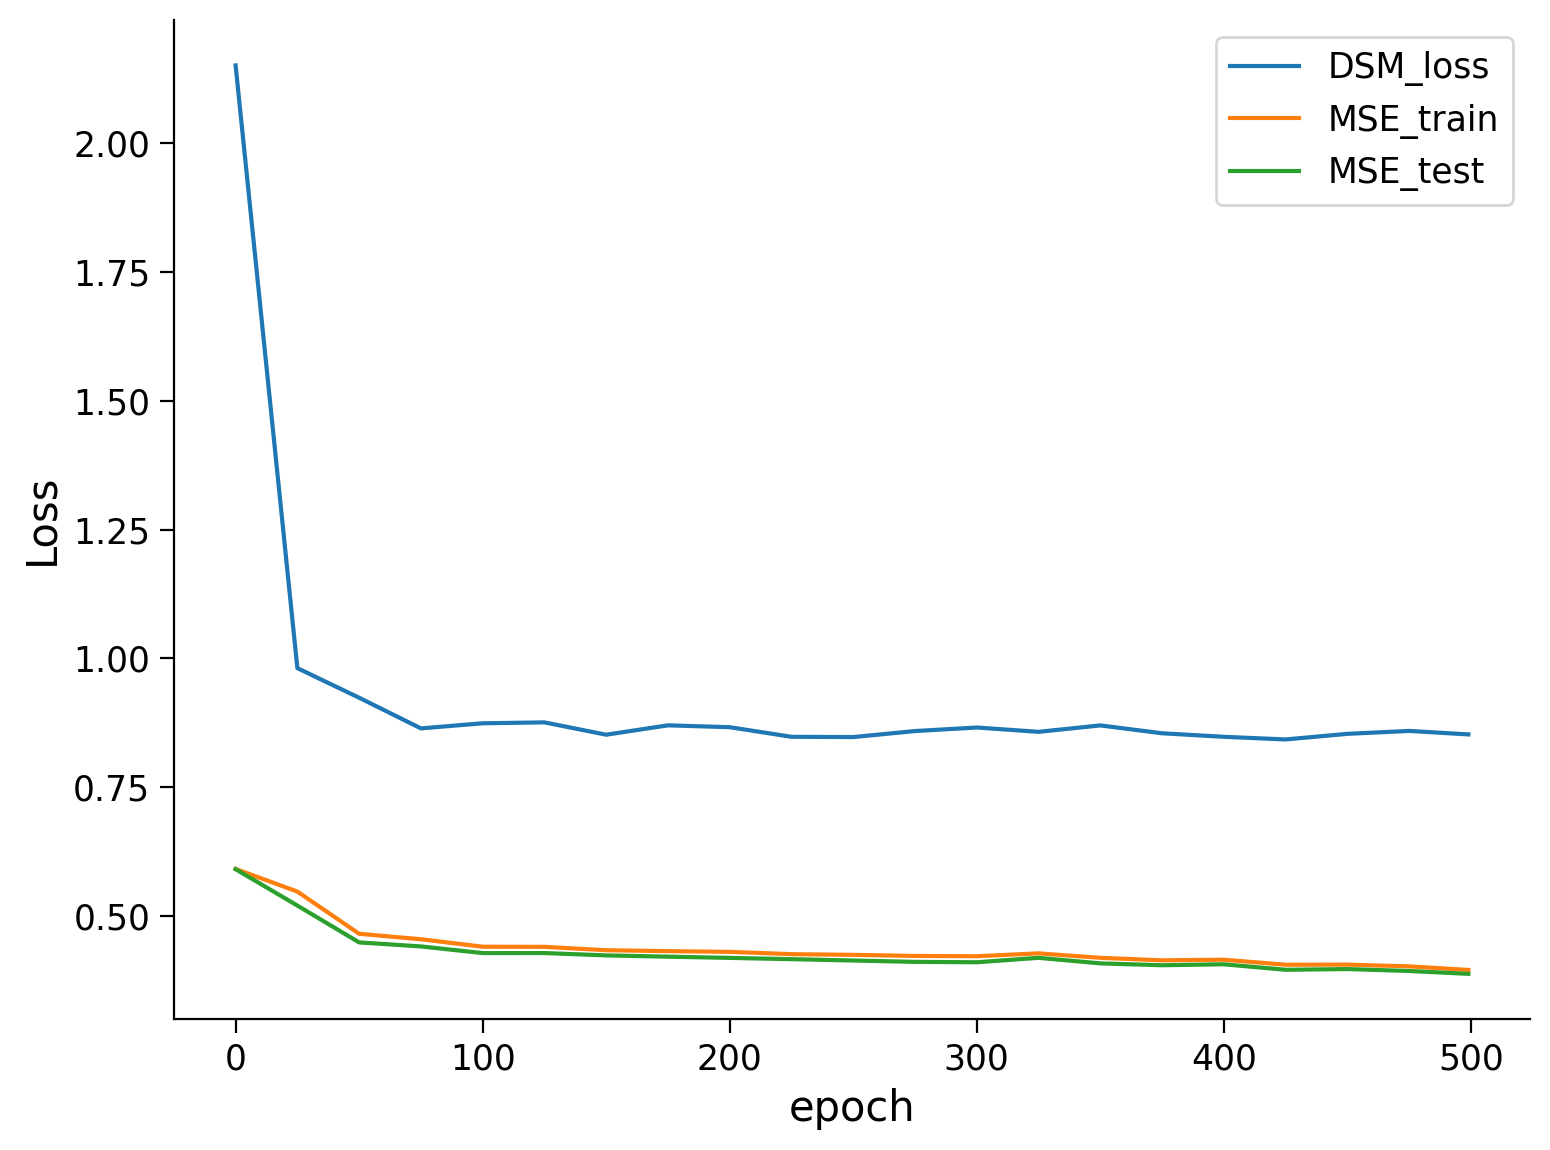

In [ ]:
# @title Plot the Loss
stats_df.plot(x="ep", y=['DSM_loss', 'MSE_train', 'MSE_test'])
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.show()

####  Test the Learned Score by Reverse Diffusion


Sample with reverse SDE using the trained score model


/tmp/ipykernel_1055542/137541647.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  self.sigma_t_fun = lambda t: np.sqrt(sigma_t_square(t, sigma))


Sample with reverse SDE using the exact score of Gaussian mixture
Sample from original Gaussian mixture
Compare the distributions


/home/lcarreira/Generative-Models-Course/.venv/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = contour_func(


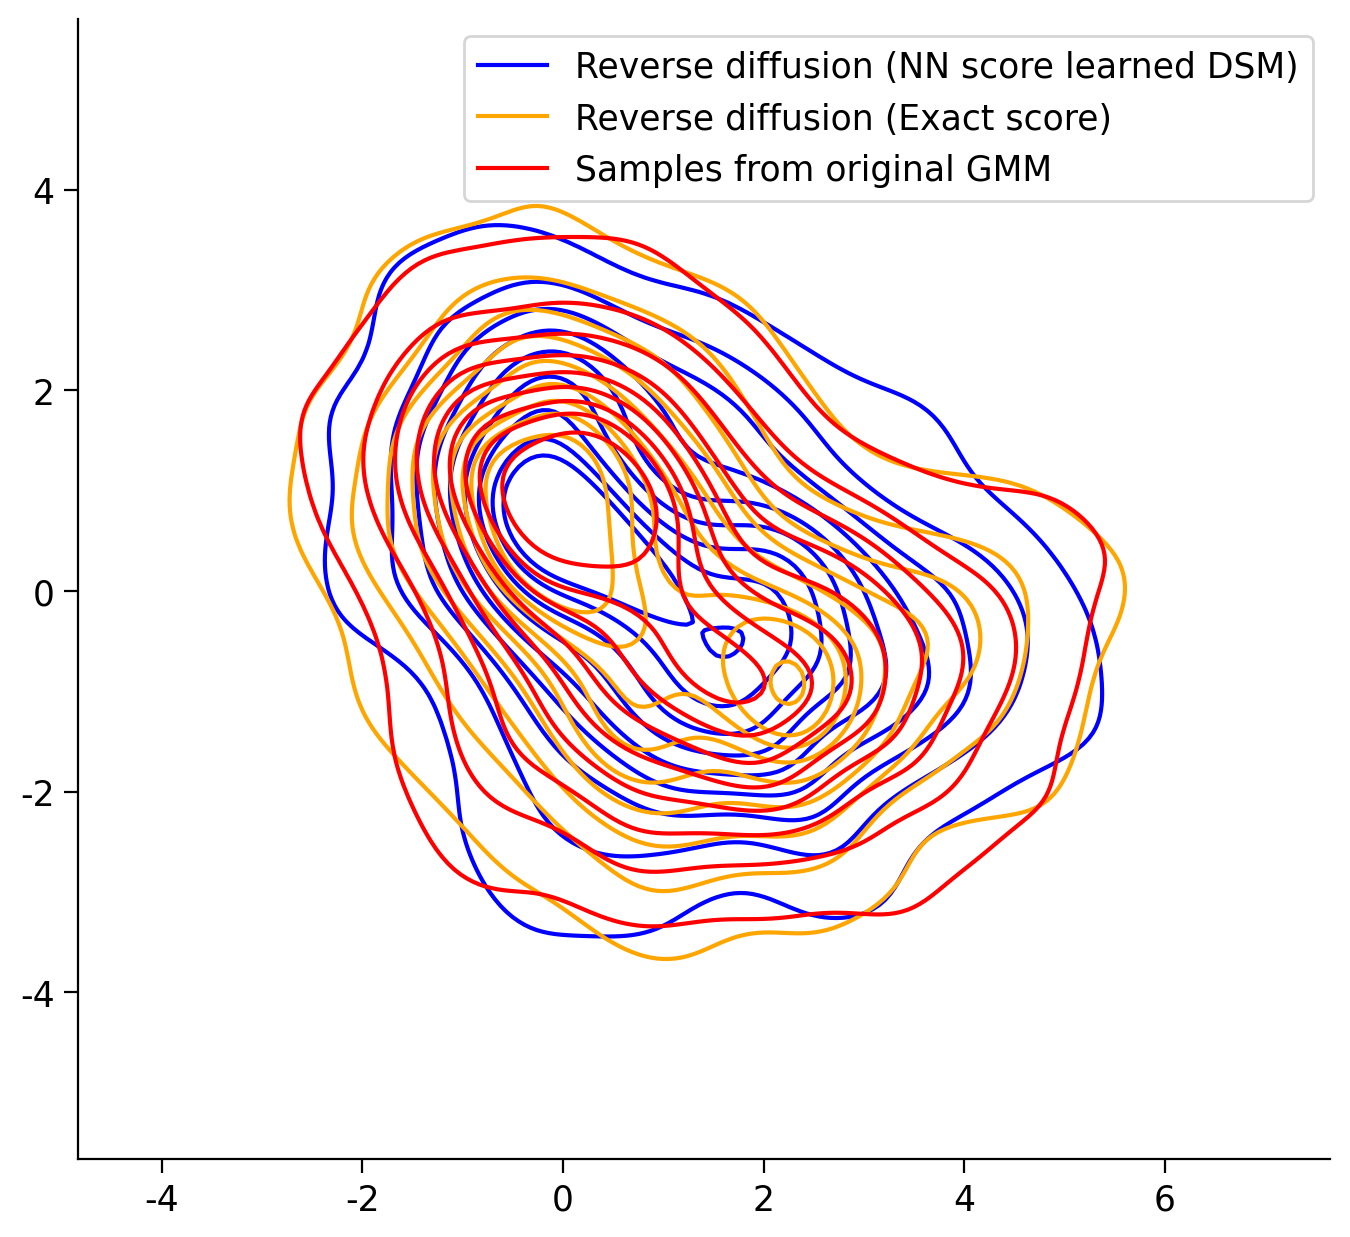

In [ ]:
# @title Test the Learned Score by Reverse Diffusion
def reverse_diffusion_SDE_sampling(score_model_td, sampN=500, Lambda=5,
                                   nsteps=200, ndim=2, exact=False):
  """
  score_model_td: if `exact` is True, use a gmm of class GaussianMixture
                  if `exact` is False. use a torch neural network that takes vectorized x and t as input.
  """
  sigmaT2 = sigma_t_square(1, Lambda)
  xT = np.sqrt(sigmaT2) * np.random.randn(sampN, ndim)
  x_traj_rev = np.zeros((*xT.shape, nsteps, ))
  x_traj_rev[:, :, 0] = xT
  dt = 1 / nsteps
  for i in range(1, nsteps):
    t = 1 - i * dt
    tvec = torch.ones((sampN)) * t
    eps_z = np.random.randn(*xT.shape)
    if exact:
      gmm_t = diffuse_gmm(score_model_td, t, Lambda)
      score_xt = gmm_t.score(x_traj_rev[:, :, i-1])
    else:
      with torch.no_grad():
        score_xt = score_model_td(torch.tensor(x_traj_rev[:, :, i-1]).float(), tvec).numpy()
    x_traj_rev[:, :, i] = x_traj_rev[:, :, i-1] + eps_z * (Lambda ** t) * np.sqrt(dt) + score_xt * dt * Lambda**(2*t)
  return x_traj_rev


print("Sample with reverse SDE using the trained score model")
x_traj_rev_appr_denois = reverse_diffusion_SDE_sampling(score_model_td,
                                                        sampN=1000,
                                                        Lambda=25,
                                                        nsteps=200,
                                                        ndim=2)
print("Sample with reverse SDE using the exact score of Gaussian mixture")
x_traj_rev_exact = reverse_diffusion_SDE_sampling(gmm, sampN=1000,
                                                  Lambda=25,
                                                  nsteps=200,
                                                  ndim=2,
                                                  exact=True)
print("Sample from original Gaussian mixture")
X_samp, _, _ = gmm.sample(1000)

print("Compare the distributions")

fig, ax = plt.subplots(figsize=[7, 7])
handles = []
kdeplot(x_traj_rev_appr_denois[:, :, -1],
        label="Reverse diffusion (NN score learned DSM)", handles=handles, color="blue")
kdeplot(x_traj_rev_exact[:, :, -1],
        label="Reverse diffusion (Exact score)", handles=handles, color="orange")
kdeplot(X_samp, label="Samples from original GMM", handles=handles, color="red", hue="kind", fill=True,)
plt.axis("image")
plt.legend(handles=handles)
plt.show()

---
# Summary

Bravo, we have come a long way today! We learned about:

* The forward and reverse diffusion processes connect the data and noise distributions.
* Sampling involves transforming noise into data through the reverse diffusion process.
* Score function is the gradient to the data distribution, enabling the diffusion process's time reversal.
* By learning to denoise, we can learn the score function of data by a function approximator, e.g., neural network.

The math that empowers the diffusion models is the reversibility of this stochastic process. Here is the general result that, given a forward diffusion process,

\begin{equation}
d\mathbf{x} = \mathbf{f}(\mathbf{x}, t)dt + g(t)d \mathbf{w}
\end{equation}

There exists a reverse time stochastic process (reverse SDE)

\begin{equation}
d\mathbf{x} =  \bigg[\mathbf{f}(\mathbf{x}, t) - g^2(t) \nabla_\mathbf{x} \log p_t(\mathbf{x}) \bigg]dt + g(t) d \mathbf{w}.
\end{equation}

and a probability flow Ordinary Differential Equation (ODE)

\begin{equation}
d\mathbf{x} = \bigg[\mathbf{f}(\mathbf{x}, t) - \frac{1}{2}g^2(t) \nabla_\mathbf{x} \log p_t(\mathbf{x})\bigg] dt.
\end{equation}

such that solving the reverse SDE or the probability flow ODE amounts to the time reversal of the solution to the forward SDE.

By this math, simulating both the ODE and the SDE can sample from diffusion models.

**References**

* [Brian Anderson, (1986) Reverse-time diffusion equation models](https://www.sciencedirect.com/science/article/pii/0304414982900515)
* [Yang Song, et al. (2020) Score-Based Generative Modeling through Stochastic Differential Equations](https://arxiv.org/abs/2011.13456)

---
# Bonus: The Math behind Score Matching Objective

How to fit the score based on the samples, when we have no access to the exact scores?

This objective is called denoising score matching. Mathematically, it utilized this [equivalence relationship](https://animadversio.github.io/academic_notes/note-on-equiv-score-matching-objective) of the following objectives.

\begin{align}
J_{DSM}(\theta) &=\mathbb E_{\tilde x,x\sim p_t(\tilde x,x)} \|s_\theta(\tilde x)-\nabla_\tilde x\log p_t(\tilde x\mid x)\|^2\\
J_{ESM}(\theta) &=\mathbb E_{\tilde x\sim p_t(\tilde x)} \|s_\theta(\tilde x)-\nabla_\tilde x\log p_t(\tilde x)\|^2
\end{align}

In practise, it's to sample $x$ from data distribution, add noise with $\sigma$ and denoise it. Since we have at time $t$, $p_t(\tilde x\mid x)= \mathcal N(\tilde x;x,\sigma^2_t I)$, then $\tilde x=x+\sigma_t z,z\sim \mathcal N(0,I)$. Then

\begin{equation}
\nabla_\tilde x\log p_t(\tilde x|x)=-\frac{1}{\sigma_t^2}(x+\sigma_t z -x)=-\frac{1}{\sigma_t}z
\end{equation}

The objective simplifies into

\begin{equation}
\mathbb E_{x\sim p_0(x)}\mathbb E_{z\sim \mathcal N(0,I)} \|s_\theta(x+\sigma_t z)+\frac{1}{\sigma_t}z\|^2
\end{equation}

Finally, in the time dependent score model $s(x,t)$, to learn this for any time $t\in [\epsilon,1]$, we integrate over all $t$ with a certain weighting function $\gamma_t$ to emphasize certain part.

\begin{equation}
\int_\epsilon^1dt \gamma_t\mathbb E_{x\sim p_0(x)}\mathbb E_{z\sim \mathcal N(0,I)} \|s_\theta(x+\sigma_t z, t)+\frac{1}{\sigma_t}z\|^2
\end{equation}

(the $\epsilon$ is set to ensure numerical stability, as $t\to 0,\sigma_t\to 0$)
Now all the expectations could be easily evaluated by sampling.

A commonly used weighting is the following:

\begin{equation}
\int_\epsilon^1dt \mathbb E_{x\sim p_0(x)}\mathbb E_{z\sim \mathcal N(0,I)} \|\sigma_t s_\theta(x+\sigma_t z, t)+z\|^2
\end{equation}


<br>

**Reference**

* [Pascal Vincent (2011), A connection between score matching and denoising autoencoders](https://www.iro.umontreal.ca/~vincentp/Publications/smdae_techreport.pdf)
